In [ ]:
#uv run ipykernel python-dotenv langchain-openai langgraph langchain

In [5]:
from dotenv import load_dotenv

load_dotenv()

True

### 기존 LangChain 코드

In [ ]:
from langchain_openai import ChatOpenAI

query = "인프런에는 어떤 강의가 있나요?"

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm.invoke(query)

AIMessage(content='인프런은 다양한 주제의 온라인 강의를 제공하는 플랫폼입니다. 주로 IT, 프로그래밍, 데이터 사이언스, 디자인, 마케팅, 비즈니스 등 여러 분야의 강의를 찾을 수 있습니다. 예를 들어, Python, Java, 웹 개발, 머신러닝, UX/UI 디자인, 디지털 마케팅 등의 강의가 있습니다. 각 강의는 강사에 따라 다르며, 초급부터 고급 과정까지 다양한 수준의 강의가 마련되어 있습니다. 특정 강의나 주제에 대한 정보가 필요하시면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 18, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f4ae844694', 'id': 'chatcmpl-D5qQfJuVnEebvMHJ6bU90al2cAAbp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c2d3d-c45b-7b83-b336-98766ddaf115-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 18, 'output_tokens': 123, 'total_to

### LangGraph
- LangGraph = State + Node + Edge, Conditional Edge
- Node: 실제 작업을 수행하는 함수 (그 자체로 에이전트일 수도 있고, 함수일 수도 있음)
- Edge: Node 사이를 "연결"함, Node 간의 실행 순서/흐름 제어.
- State: 그래프에서 데이터를 전달하는 공유 공간

### LangGraph 만들기
    1. State 정의 
    2. Node 정의
    3. StateGraph로 그래프 빌더 생성 (설계도)
    4. 그래프 빌더에 Node 추가 
    5. 그래프 빌더에 Edge 추가 
    6. 그래프 compile (생성)
    7. State 생성 -> 그래프 invoke (실행)

## 🎯 LangGraph 핵심 동작 원리

### 1️⃣ LangGraph의 2가지 약속 (설계 철학)

**약속 1: 모든 Node는 State를 파라미터로 받는다**
```python
def my_node(state: AgentState):  # 👈 반드시 state 파라미터
    # ... 작업 수행
```

**약속 2: Node는 State 업데이트 내용을 반환한다**
```python
def my_node(state: AgentState):
    return {"messages": [new_message]}  # 👈 업데이트할 부분만 반환
    # LangGraph가 자동으로 기존 state와 병합!
```

---

### 2️⃣ State란?

- **역할**: 그래프 내 모든 Node가 공유하는 데이터 컨테이너
- **필수**: 반드시 dict-like 구조 (키-값 쌍)
- **타입**: TypedDict, Pydantic, dataclass, dict 모두 가능

```python
# State는 컨테이너여야 함
class AgentState(TypedDict):
    messages: list  # 필드(field) 또는 속성(attribute)
    count: int
```

---

### 3️⃣ State 필드의 업데이트 방식

**추가 방식 (Annotated + Reducer)**
```python
messages: Annotated[list, add_messages]
# 기존 값에 새 값 추가
```

**교체 방식 (기본)**
```python
counter: int  # Annotated 없으면 값을 교체(덮어쓰기)
```

**커스텀 방식**
```python
def merge_lists(old, new):
    return list(set(old + new))

tags: Annotated[list, merge_lists]
```

---

### 4️⃣ 실행 흐름

```
State 입력 
  ↓
Node 1 실행 → State 업데이트 (LangGraph가 자동 병합)
  ↓
Node 2 실행 → State 업데이트
  ↓
Node 3 실행 → State 업데이트
  ↓
최종 State 반환
```

---

### 5️⃣ StateGraph vs Graph

- **StateGraph**: 그래프 빌더 (설계도) - Node와 Edge를 추가하는 단계
- **Graph**: `compile()` 후 실제 실행 가능한 그래프

```python
graph_builder = StateGraph(AgentState)  # 빌더
graph_builder.add_node(...)
graph_builder.add_edge(...)

graph = graph_builder.compile()  # 실행 가능한 그래프
graph.invoke(initial_state)      # 실행
```

---

### 💡 핵심 정리

1. LangGraph = **상태 기반 그래프** 프레임워크
2. State는 모든 Node가 **공유하는 데이터 공간**
3. Node는 State를 받아서 **일부만 업데이트**
4. LangGraph가 **자동으로 병합**해서 다음 Node로 전달
5. 각 필드의 **업데이트 방식을 설계**하는 것이 중요!

In [ ]:
#langgraph 코드 
from typing import TypedDict, Annotated

from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage

# 1. State 정의 
class AgentState(TypedDict):
    # 필드(속성) 정의 
    # 필드 정의할 때 업데이트 방식을 정의하지 않으면 랭그래프가 그냥 교체 방식을 적용함 (덮어쓰기)
    messages: list[Annotated[AnyMessage, add_messages]] #필드 업데이트 방식으로 add_messages 사용 

In [ ]:
# 2. Node
def generate(state: AgentState) -> AgentState:
    messages = state["messages"]
    ai_message = llm.invoke(messages)
    return {"messages": [ai_message]}

In [ ]:
from langgraph.graph import StateGraph

# 3. StateGraph: Node 간의 관계 정의하는 그래프 빌더 
graph_builder = StateGraph(AgentState)

In [ ]:
from langgraph.graph import END, START

# 4. 그래프 빌더에 Node 추가 
graph_builder.add_node("generate", generate)

# 5. 그래프 빌더에 Edge 추가 
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

In [11]:
# 그래프 빌더에서 그래프 생성 
graph = graph_builder.compile()

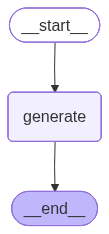

In [12]:
# Mermaid로 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langchain_core.messages import HumanMessage

# state 생성 -> 그래프 실행 
initial_state = {"messages": [HumanMessage(query)]}
graph.invoke(initial_state)

{'messages': [AIMessage(content='인프런은 다양한 주제의 온라인 강의를 제공하는 플랫폼입니다. 주로 IT, 프로그래밍, 데이터 과학, 디자인, 마케팅, 비즈니스 등 여러 분야의 강의를 찾을 수 있습니다. 예를 들어, Python, Java, 웹 개발, 머신러닝, UX/UI 디자인, 디지털 마케팅 등의 강의가 있습니다. 각 강의는 강사에 따라 내용과 수준이 다르므로, 자신의 필요에 맞는 강의를 선택할 수 있습니다. 인프런 웹사이트를 방문하면 최신 강의 목록과 상세 정보를 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 18, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6c0d1490cb', 'id': 'chatcmpl-D5qUCOqHT8oRhonOAmNObNdKMr7Mz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c2d41-1b7b-75c0-bf95-7e1c7d48ca80-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 18, 'output_